In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
fastai.__version__

'1.0.28'

In [3]:
from fastai import *
from fastai_audio import *

from fastai.vision import models

In [4]:
DATA = Path('data')
AUDIOSET = DATA/'audioset_mono'

TRAIN_AUDIO = AUDIOSET/'train'
TRAIN_CSV = AUDIOSET/'train_segments_cl.csv'
TRAIN_LENGTHS_CSV = AUDIOSET/'train_n_samples_per_file.csv'

LABELS_CSV = AUDIOSET/'class_labels_indices.csv'

In [5]:
label_df = pd.read_csv(LABELS_CSV, index_col='mid', usecols=['mid', 'display_name'])
print(label_df.shape)
label_df.head()

(527, 1)


,display_name
mid,
/m/09x0r,Speech
/m/05zppz,"Male speech, man speaking"
/m/02zsn,"Female speech, woman speaking"
/m/0ytgt,"Child speech, kid speaking"
/m/01h8n0,Conversation


In [6]:
train_df = pd.read_csv(TRAIN_CSV, sep=' ')
train_n_samples_df = pd.read_csv(TRAIN_LENGTHS_CSV)

train_df['fname'] = train_df['YTID'] + train_df['start_seconds'].apply(lambda x: f"_{x:.3f}")
train_df['label_str'] = train_df['positive_labels'].apply(lambda s: label_df.loc[s.split(','), 
                                                                                 'display_name'].tolist())
train_df['n_samples'] = train_n_samples_df['n_samples']
train_df = train_df[['fname', 'label_str', 'n_samples']]
train_df.head()

,fname,label_str,n_samples
0,--ZhevVpy1s_50.000,[Toothbrush],220500
1,--aE2O5G5WE_0.000,"[Goat, Music, Speech]",220500
2,--aO5cdqSAg_30.000,"[Male singing, Child singing]",220500
3,--aaILOrkII_200.000,"[Gunshot, gunfire, Cap gun]",220500
4,--cB2ZVjpnA_30.000,"[Smoke detector, smoke alarm]",220500


Only use the rows which have exactly 220500 samples for now

In [7]:
train_df_same = train_df[train_df['n_samples'] == 220500]
len(train_df), len(train_df_same)

(18725, 17188)

In [14]:
n_fft = 2048
n_hop = 256
n_mels = 128
sr = 22050
top_db = 60.0
ref = 1.0

bs = 16

mel_spec_tfm = Compose([
    Spectrogram(n_fft=n_fft, n_hop=n_hop),
    FrequencyToMel(n_mels=n_mels, n_fft=n_fft, sr=sr, f_min=0., f_max=None),
    SpectrumToDb(ref=ref, top_db=top_db, normalized=True)
])

def inputs_tfm(inputs):
    x, y = inputs
    # 1d time domain signal to 2d log melspectrogram (frequency domain)
    x = mel_spec_tfm(x)
    # add channel dimension
    x.unsqueeze_(1)    
    return x, y

tfms = [inputs_tfm]

In [12]:
def precision(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between preds and targets"
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    return prec.mean()

In [13]:
def recall(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, eps:float=1e-9, sigmoid:bool=True) -> Rank0Tensor:
    "Computes the f_beta between preds and targets"
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    rec = TP/(y_true.sum(dim=1)+eps)
    return rec.mean()

In [14]:
fbeta5 = partial(fbeta, thresh=0.5)
precision5 = partial(precision, thresh=0.5)
recall5 = partial(recall, thresh=0.5)

In [15]:
metrics = [precision, recall, fbeta, precision5, recall5, fbeta5]

In [13]:
df = train_df_same
print(len(df))

data = (AudioItemList
            .from_df(df, path=AUDIOSET, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .databunch(bs=bs, tfms=tfms, equal_lengths=True))
data.c, data.classes[:5], bs

17188


(527,
 ['Air brake', 'Tick', 'Bee, wasp, etc.', 'Music of Africa', 'Tambourine'],
 16)

### ResNet 18

In [15]:
arch = models.resnet18
model_name = 'audioset_2048_256_128_60db_res18'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

Total time: 05:00
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.024959    0.023190    0.373994   0.171475  0.189356  0.181845   0.072848  0.082220  (00:38)
2      0.022315    0.021384    0.394737   0.180868  0.198019  0.252948   0.103771  0.116348  (00:37)
3      0.022018    0.020361    0.402889   0.194827  0.212551  0.258472   0.104830  0.117996  (00:37)
4      0.021018    0.019606    0.419129   0.215446  0.231580  0.278179   0.114970  0.128750  (00:37)
5      0.020093    0.019306    0.418203   0.212810  0.229560  0.252817   0.105104  0.117649  (00:37)
6      0.019192    0.019015    0.427641   0.215630  0.232361  0.296743   0.126141  0.140578  (00:37)
7      0.018513    0.018761    0.426964   0.231374  0.245891  0.315888   0.137314  0.152418  (00:37)
8      0.018666    0.018725    0.421892   0.234688  0.248090  0.313143   0.134332  0.149232  (00:37)



In [16]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1);

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


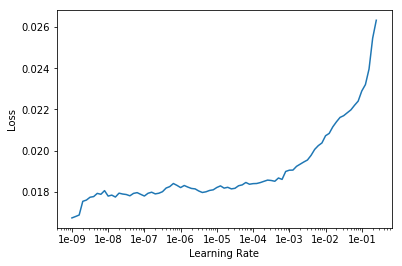

In [17]:
learn.recorder.plot()

In [18]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-5))
learn.save(model_name + '-stage-2')

Total time: 07:39
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.018757    0.018701    0.429734   0.229593  0.244666  0.304172   0.131344  0.145905  (00:46)
2      0.018526    0.018680    0.427731   0.233602  0.247988  0.313425   0.135199  0.150210  (00:45)
3      0.018260    0.018648    0.432254   0.230539  0.245784  0.305482   0.131419  0.146000  (00:45)
4      0.018188    0.018582    0.431054   0.235464  0.249864  0.324932   0.141458  0.156935  (00:45)
5      0.018250    0.018607    0.426048   0.235505  0.248987  0.307263   0.135079  0.149426  (00:45)
6      0.018250    0.018641    0.429310   0.231725  0.246296  0.305598   0.133194  0.147645  (00:45)
7      0.018286    0.018508    0.434654   0.237492  0.252295  0.325189   0.141174  0.156617  (00:46)
8      0.017808    0.018505    0.436986   0.237804  0.252634  0.326934   0.142284  0.157712  (00:45)
9      0.018017    0.018559    0.428512   0.241999  0.255169  0.331895   0.146226 

### ResNet 34

In [19]:
arch = models.resnet34
model_name = 'audioset_2048_256_128_60db_res34'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

Total time: 07:04
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.024937    0.023080    0.383498   0.161928  0.180781  0.166861   0.067166  0.075764  (00:52)
2      0.022401    0.021136    0.383387   0.186015  0.203455  0.251964   0.100938  0.113719  (00:53)
3      0.021681    0.020177    0.393002   0.194024  0.210978  0.281951   0.114170  0.128512  (00:53)
4      0.020516    0.019640    0.402734   0.200267  0.217328  0.256163   0.104982  0.117887  (00:53)
5      0.019946    0.019117    0.412815   0.211914  0.227361  0.270565   0.113828  0.127241  (00:52)
6      0.019334    0.018831    0.422228   0.228254  0.242423  0.305322   0.129736  0.144458  (00:53)
7      0.018766    0.018586    0.425763   0.234425  0.248679  0.332627   0.142020  0.158190  (00:53)
8      0.018585    0.018629    0.424670   0.232162  0.246331  0.312256   0.135130  0.149944  (00:53)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


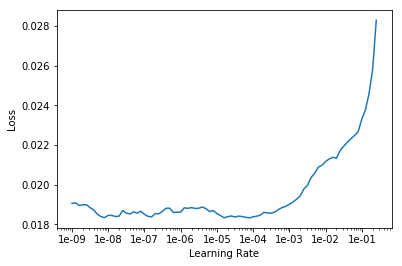

In [20]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1)
learn.recorder.plot()

In [22]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))
learn.save(model_name + '-stage-2')

Total time: 11:16
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.018307    0.018556    0.425888   0.233299  0.247637  0.316053   0.135831  0.150968  (01:07)
2      0.018268    0.018570    0.426707   0.238002  0.251917  0.325150   0.141835  0.157243  (01:07)
3      0.018046    0.018557    0.432245   0.235765  0.250387  0.320301   0.138601  0.153766  (01:07)
4      0.017949    0.018407    0.430928   0.240722  0.254457  0.320592   0.140689  0.155769  (01:07)
5      0.018025    0.018460    0.430394   0.236685  0.250548  0.324040   0.140898  0.156242  (01:07)
6      0.017675    0.018372    0.426478   0.240831  0.253559  0.316184   0.140120  0.154693  (01:07)
7      0.017288    0.018379    0.427632   0.242009  0.254946  0.318570   0.140646  0.155486  (01:07)
8      0.017052    0.018452    0.433128   0.236028  0.250478  0.318065   0.139497  0.154414  (01:07)
9      0.016947    0.018314    0.432261   0.243759  0.256877  0.322847   0.142232 

### ResNet 50

In [24]:
arch = models.resnet50
model_name = 'audioset_2048_256_128_60db_res50'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

Total time: 12:14
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.024519    0.023013    0.390311   0.170750  0.189849  0.186645   0.076147  0.085777  (01:44)
2      0.022897    0.020939    0.406630   0.187488  0.205503  0.225473   0.092705  0.104265  (01:29)
3      0.020693    0.020017    0.435971   0.207433  0.226027  0.296237   0.121009  0.135808  (01:29)
4      0.020539    0.019465    0.415127   0.218723  0.233180  0.276132   0.118296  0.131475  (01:29)
5      0.019478    0.018810    0.426293   0.224475  0.239062  0.221209   0.096154  0.106731  (01:30)
6      0.018822    0.018368    0.426078   0.254043  0.262571  0.347906   0.155243  0.171178  (01:30)
7      0.018293    0.018284    0.440913   0.242772  0.256693  0.322274   0.142260  0.157500  (01:30)
8      0.017232    0.018329    0.432260   0.248483  0.260105  0.318700   0.143751  0.158401  (01:31)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


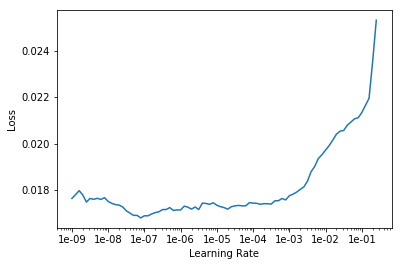

In [25]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1)
learn.recorder.plot()

In [26]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))
learn.save(model_name + '-stage-2')

Total time: 19:27
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.017141    0.018147    0.440341   0.251927  0.264183  0.338155   0.149895  0.165779  (01:58)
2      0.017531    0.018337    0.437747   0.248215  0.260229  0.314854   0.139958  0.154410  (01:56)
3      0.016954    0.018122    0.445036   0.250216  0.263315  0.337666   0.148796  0.164563  (01:57)
4      0.017180    0.018152    0.443042   0.255210  0.267465  0.336839   0.149277  0.164771  (01:56)
5      0.016842    0.018089    0.442378   0.261363  0.272100  0.352272   0.157120  0.173281  (01:56)
6      0.016571    0.018073    0.440942   0.256418  0.268135  0.334350   0.149515  0.164626  (01:56)
7      0.016526    0.018112    0.443881   0.251459  0.264441  0.334562   0.148803  0.164064  (01:56)
8      0.016355    0.018126    0.438953   0.256619  0.267699  0.309783   0.141354  0.155103  (01:56)
9      0.016053    0.018171    0.439753   0.254155  0.265753  0.318380   0.145456 

### ResNet 100

In [27]:
arch = models.resnet101
model_name = 'audioset_2048_256_128_60db_res101'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

Total time: 19:06
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.024802    0.023130    0.370378   0.164539  0.182444  0.228542   0.091981  0.103750  (02:22)
2      0.022139    0.020945    0.386121   0.185274  0.201898  0.211754   0.085759  0.096436  (02:23)
3      0.021346    0.019730    0.395580   0.213793  0.226623  0.295392   0.122618  0.137125  (02:23)
4      0.019875    0.019247    0.419414   0.214661  0.230649  0.303092   0.125786  0.140598  (02:23)
5      0.019577    0.018549    0.443455   0.232522  0.247847  0.338391   0.141226  0.157426  (02:23)
6      0.018704    0.018038    0.423997   0.255033  0.263995  0.332831   0.150886  0.165872  (02:23)
7      0.017544    0.018023    0.435982   0.252166  0.263288  0.338456   0.152352  0.167584  (02:23)
8      0.017076    0.018019    0.433684   0.254077  0.264710  0.331390   0.151061  0.165905  (02:23)



## STFT Only

In [9]:
n_fft = 1024
n_hop = 256
sr = 22050
top_db = 60.0
ref = 1.0

bs = 16

mel_spec_tfm = Compose([
    Spectrogram(n_fft=n_fft, n_hop=n_hop),
    SpectrumToDb(ref=ref, top_db=top_db, normalized=True)
])

def inputs_tfm(inputs):
    x, y = inputs
    # 1d time domain signal to 2d log melspectrogram (frequency domain)
    x = mel_spec_tfm(x)
    # add channel dimension
    x.unsqueeze_(1)    
    return x, y

tfms = [inputs_tfm]
data = (AudioItemList
            .from_df(train_df_same, path=AUDIOSET, folder='train', suffix='.wav')
            .random_split_by_pct()
            .label_from_df()
            .databunch(bs=bs, tfms=tfms, equal_lengths=True))

### ResNet 18

In [16]:
arch = models.resnet18
model_name = 'audioset_stft_1024_256_60db_res18'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


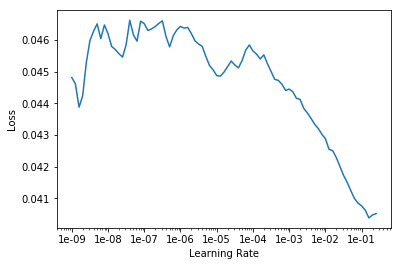

In [17]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1)
learn.recorder.plot();

In [ ]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))
learn.save(model_name + '-stage-2')

### ResNet 34

In [18]:
arch = models.resnet34
model_name = 'audioset_stft_1024_256_60db_res34'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

Total time: 21:22
epoch  train_loss  valid_loss  precision  recall  fbeta  precision  recall  fbeta          
1      0.024626    0.022865    0.388468   0.178480  0.196821  0.223887   0.089552  0.100990  (02:41)
2      0.021723    0.020409    0.399433   0.184285  0.202991  0.237998   0.096546  0.108791  (02:39)
3      0.020882    0.019042    0.405474   0.206446  0.222458  0.272403   0.110446  0.124041  (02:40)
4      0.019368    0.018606    0.418180   0.213299  0.229152  0.301620   0.124899  0.139874  (02:40)
5      0.018834    0.017862    0.424184   0.235995  0.248813  0.310919   0.134519  0.149079  (02:40)
6      0.018402    0.017275    0.430232   0.272475  0.280408  0.351443   0.157316  0.173372  (02:40)
7      0.017291    0.017378    0.438370   0.253591  0.265905  0.335628   0.148573  0.164047  (02:40)
8      0.016917    0.017173    0.439084   0.266924  0.276868  0.339176   0.151263  0.166805  (02:40)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


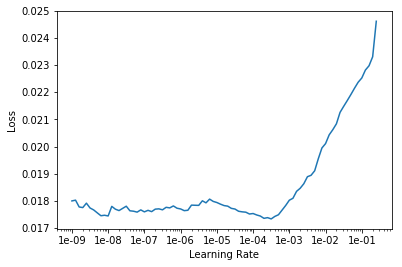

In [20]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1)
learn.recorder.plot();

In [21]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(8, max_lr=slice(3e-6, 3e-5))
learn.save(model_name + '-stage-2')

epoch,train_loss,valid_loss,precision,recall,fbeta,precision,recall,fbeta
1,0.017240,0.017164,0.441986,0.266857,0.276977,0.340650,0.152753,0.168278
2,0.017356,0.017059,0.441925,0.271931,0.281661,0.337725,0.154928,0.169821
3,0.016648,0.017028,0.446617,0.268341,0.278582,0.338902,0.153997,0.169344


KeyboardInterrupt: 

### ResNet 50

In [ ]:
arch = models.resnet50
model_name = 'audioset_1024_256_128_60db_res50'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

In [ ]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1)
learn.recorder.plot();

In [ ]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))
learn.save(model_name + '-stage-2')

### ResNet 101

In [ ]:
arch = models.resnet101
model_name = 'audioset_1024_256_128_60db_res101'

learn = create_cnn(data, arch, metrics=metrics)
learn.fit_one_cycle(8)
learn.save(model_name + '-stage-1')

In [ ]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1)
learn.recorder.plot();

In [ ]:
learn.load(model_name + '-stage-1')
learn.unfreeze()
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))
learn.save(model_name + '-stage-2')